In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# --- LOADING DATA ---
# Load the CSV files
general_data = pd.read_csv("data/general_data.csv")
employee_data = pd.read_csv("data/employee_survey_data.csv")
manager_data = pd.read_csv("data/manager_survey_data.csv")
in_time_data = pd.read_csv("data/in_time.csv")
out_time_data = pd.read_csv("data/out_time.csv")

In [3]:
# Merging tables on employee ID
df = ( general_data
    .merge(employee_data, on="EmployeeID", how="left")
    .merge(manager_data,  on="EmployeeID", how="left")
)

# df.info()

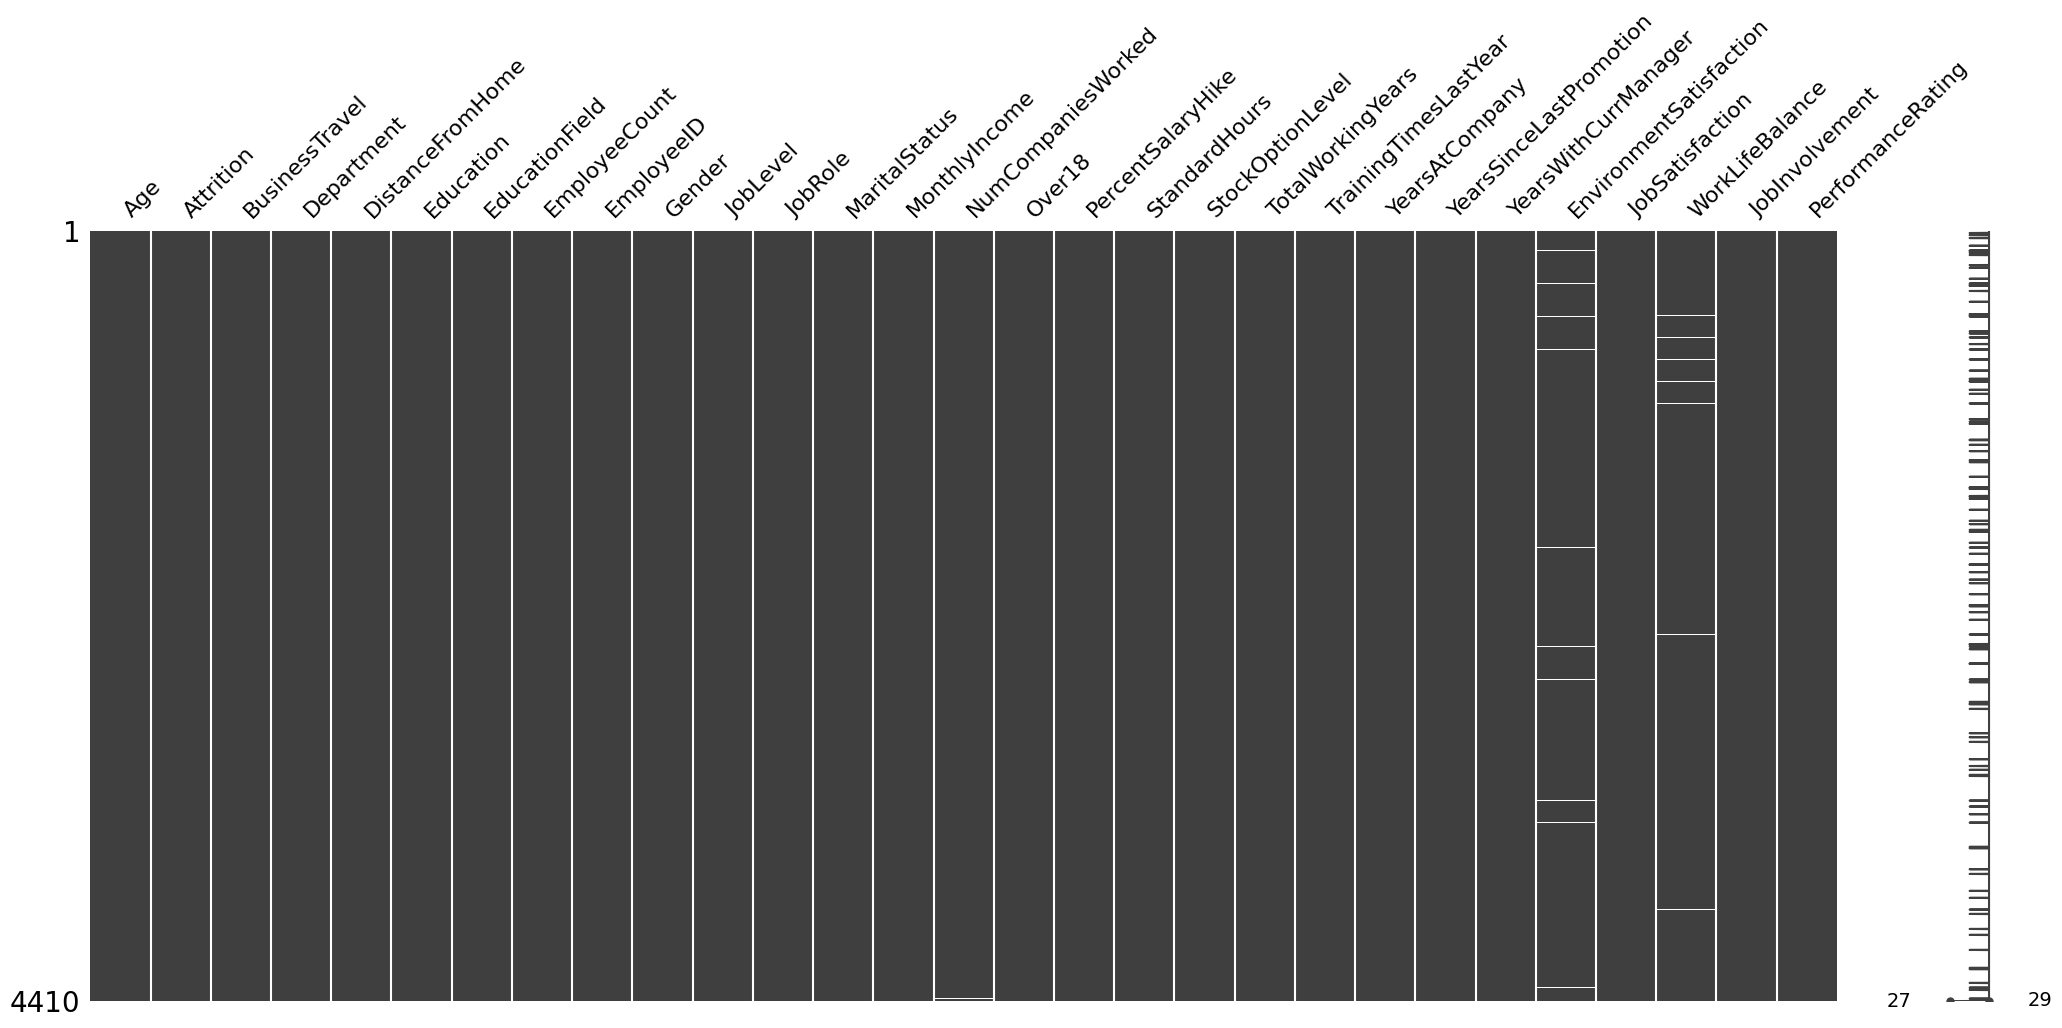

In [4]:
# Visualize missing data
msno.matrix(df)
plt.show()

In [5]:
# --- 1. DATA PREPARATION ---
print(f"Initial data size: {len(df)}")

# Clean up the data first: Drop useless columns
cols_to_drop = ['EmployeeID', 'StandardHours', 'Over18', 'EmployeeCount']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# Drop rows with missing target
df_clean = df_clean.dropna(subset=['Attrition'])

Initial data size: 4410


In [6]:
# --- FEATURE ENGINEERING ---
def add_features(data):
    df_eng = data.copy()
    
    # 1. Satisfaction Aggregation
    # Summing up discrete satisfaction scores to get an overall 'happiness' metric
    satisfaction_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement']
    # Fill NaNs with median for these calculations to avoid losing rows or getting NaNs in new features
    for col in satisfaction_cols:
        if col in df_eng.columns:
            df_eng[col] = df_eng[col].fillna(df_eng[col].median())
            
    df_eng['TotalSatisfaction'] = df_eng[satisfaction_cols].sum(axis=1)
    df_eng['AvgSatisfaction'] = df_eng[satisfaction_cols].mean(axis=1)
    
    # 2. Tenure/Loyalty Ratios
    # Years at company relative to age (proportion of life spent there)
    df_eng['YearsAtCompanyPerYear'] = df_eng['YearsAtCompany'] / (df_eng['Age'] + 1e-5)
    # Average tenure per job held
    df_eng['WorkingYearsPerCompany'] = df_eng['TotalWorkingYears'] / (df_eng['NumCompaniesWorked'] + 1)
    
    return df_eng

df_clean = add_features(df_clean)

In [7]:
# --- 2. SEPARATING TARGET / FEATURES ---
X = df_clean.drop("Attrition", axis=1)
y = df_clean["Attrition"].copy()

# Encode Target (Yes/No -> 1/0)
y = y.map({'Yes': 1, 'No': 0})

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {len(X_train)}")

Training set size: 3528


In [8]:
# 3. --- PREPROCESSING (PIPELINE) ---
num_attribs = list(X_train.select_dtypes(include=[np.number]).columns)
cat_attribs = list(X_train.select_dtypes(include=['object']).columns)

print('numerical_columns : ', num_attribs)
print('categorical columns : ', cat_attribs)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

# sparse_output=False ensures we get a dense matrix, easier for the correlation dataframe
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_attribs),
])

numerical_columns :  ['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'TotalSatisfaction', 'AvgSatisfaction', 'YearsAtCompanyPerYear', 'WorkingYearsPerCompany']
categorical columns :  ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']


In [9]:
# --- 4. EXECUTION ---
print("Executing preprocessing...")
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

Executing preprocessing...


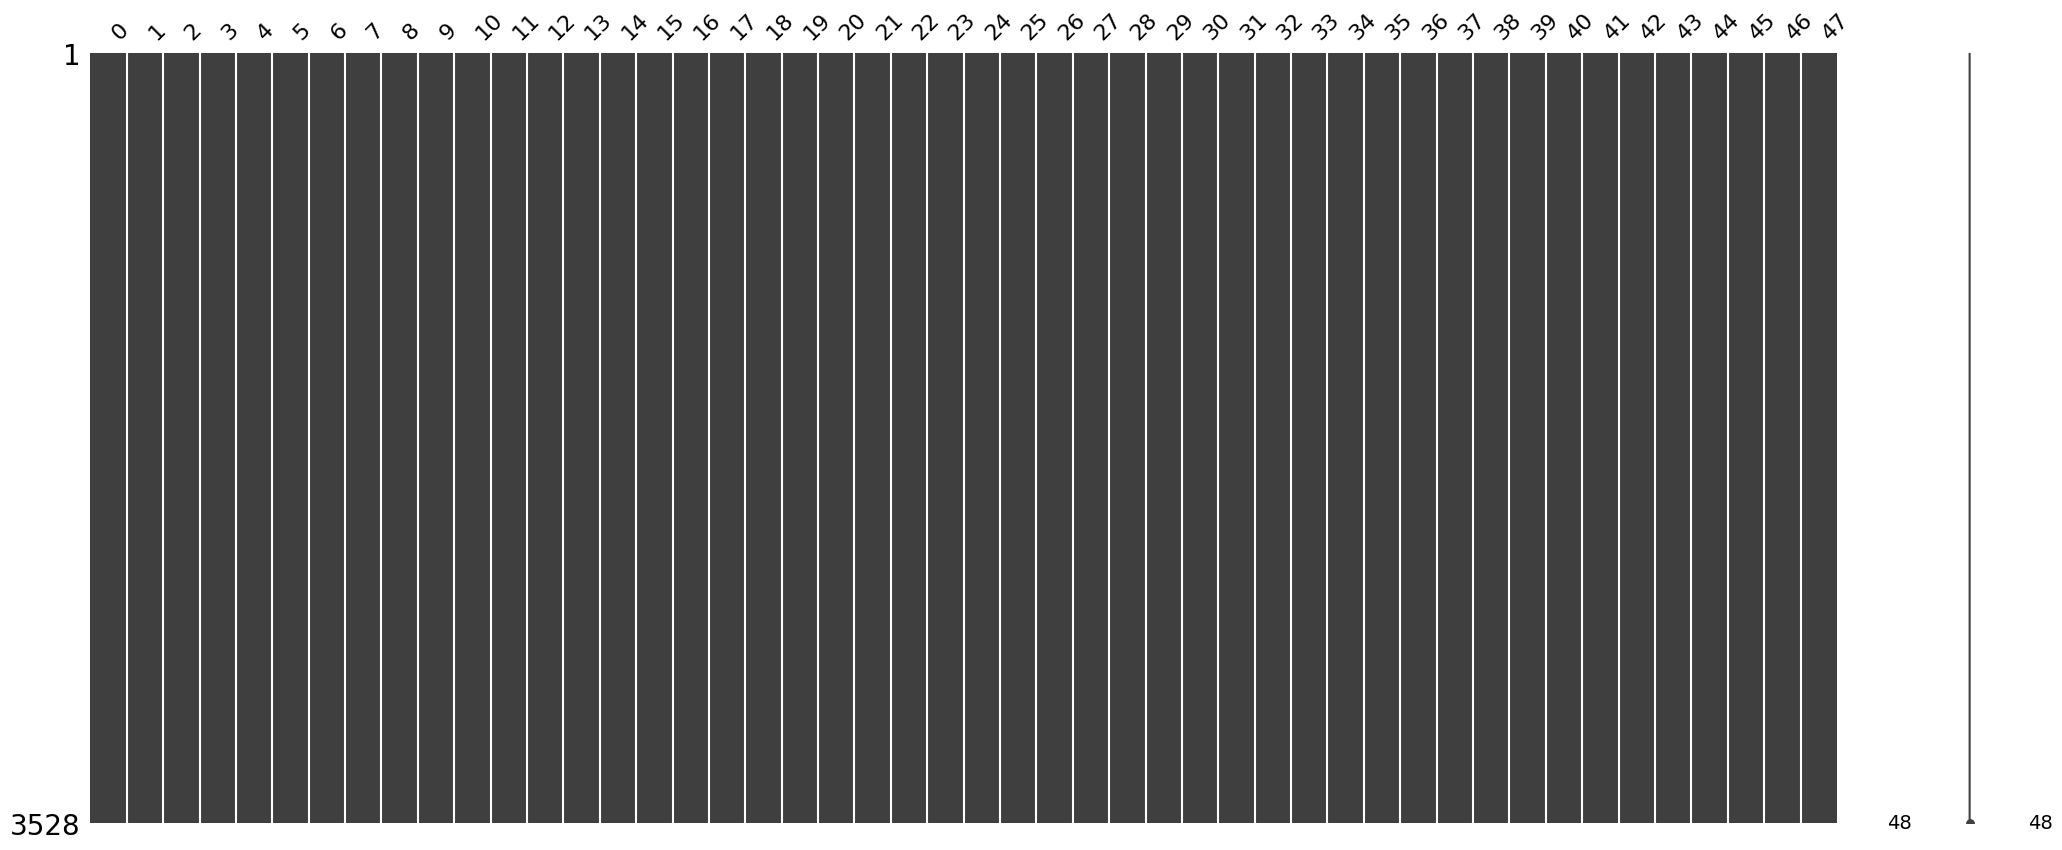

Missing values after preprocessing:
Series([], dtype: int64)


In [10]:
# Validating the imputation
msno.matrix(pd.DataFrame(X_train_prepared))
plt.show()
print("Missing values after preprocessing:")
missing_values = pd.DataFrame(X_train_prepared).isnull().sum()
print(missing_values[missing_values > 0]) # Should be empty


In [11]:
# --- STATISTICAL ANALYSIS ---
print("\n--- Statistical Analysis (Feature Selection Check) ---")
# Retrieve feature names from pipeline
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_features_names = list(cat_encoder.get_feature_names_out(cat_attribs))
all_features_names = num_attribs + cat_features_names

# Create a DataFrame to analyze correlations
train_df_processed = pd.DataFrame(X_train_prepared, columns=all_features_names)
train_df_processed['Attrition'] = y_train.values

# Compute correlation with the target
corr_matrix = train_df_processed.corr()
attrition_corr = corr_matrix['Attrition'].sort_values(ascending=False)

print("Top 10 Positively Correlated Features (Risk Factors):")
print(attrition_corr.iloc[1:11]) # 0 is Attrition itself
print("\nTop 10 Negatively Correlated Features (Retention Factors):")
print(attrition_corr.tail(10))


--- Statistical Analysis (Feature Selection Check) ---
Top 10 Positively Correlated Features (Risk Factors):
MaritalStatus_Single                0.184688
BusinessTravel_Travel_Frequently    0.113523
EducationField_Human Resources      0.090823
Department_Human Resources          0.073982
NumCompaniesWorked                  0.035943
Gender_Male                         0.028459
JobRole_Sales Executive             0.027309
JobRole_Research Director           0.024505
JobRole_Research Scientist          0.024009
PercentSalaryHike                   0.021249
Name: Attrition, dtype: float64

Top 10 Negatively Correlated Features (Retention Factors):
MaritalStatus_Married    -0.101028
JobSatisfaction          -0.106243
AvgSatisfaction          -0.147512
TotalSatisfaction        -0.147512
YearsAtCompany           -0.151274
YearsAtCompanyPerYear    -0.151658
WorkingYearsPerCompany   -0.158814
YearsWithCurrManager     -0.163094
Age                      -0.167628
TotalWorkingYears        -0.17669

In [ ]:
# --- BIVARIATE STATISTICAL ANALYSIS ---
if 'train_df_processed' in locals():
    sns.pairplot(train_df_processed[num_attribs + ['Attrition']], hue='Attrition')
else:
    print('train_df_processed not found. Please run the Statistical Analysis cell first.')
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001EB423FAFC0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# --- 5. MODEL TRAINING AND EVALUATION ---
print("\n--- Model Training and Evaluation ---")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42)
forest_clf = RandomForestClassifier(n_estimators=30, random_state=42)

models = [
    ("Logistic Regression", log_reg),
    ("Decision Tree", tree_clf),
    ("Random Forest", forest_clf)
]

print("Starting Cross-Validation (5 folds)...")

for name, model in models:
    print(f"Evaluating {name}...")
    scores = cross_validate(model, X_train_prepared, y_train,
                            scoring=["accuracy", "f1"], cv=5)
    
    acc_scores = scores["test_accuracy"]
    f1_scores = scores["test_f1"]
    
    print(f"  Mean Accuracy: {acc_scores.mean():.4f}")
    print(f"  Mean F1 Score: {f1_scores.mean():.4f}")
    print("-" * 30)



--- Model Training and Evaluation ---
Starting Cross-Validation (5 folds)...
Evaluating Logistic Regression...
  Mean Accuracy: 0.8569
  Mean F1 Score: 0.3263
------------------------------
Evaluating Decision Tree...
  Mean Accuracy: 0.9660
  Mean F1 Score: 0.8940
------------------------------
Evaluating Random Forest...
  Mean Accuracy: 0.9779
  Mean F1 Score: 0.9270
------------------------------


In [ ]:
# --- 6. HYPERPARAMETER OPTIMIZATION ---
print("\n--- Hyperparameter Optimization (Grid Search) ---")
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [100, 150, 200], 'max_features': [4, 6, 8]},
]

forest_clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='f1',
                           return_train_score=True)

print("Running Grid Search (this may take a while)...")
grid_search.fit(X_train_prepared, y_train)

print("\nBest Parameters found:")
print(grid_search.best_params_)

best_score = grid_search.best_score_
print(f"Best F1 Score (Cross-Validation): {best_score:.4f}")


--- Hyperparameter Optimization (Grid Search) ---
Running Grid Search (this may take a while)...

Best Parameters found:
{'max_features': 8, 'n_estimators': 150}
Best F1 Score (Cross-Validation): 0.9346


In [ ]:
# --- FEATURE IMPORTANCE ---
print("\n--- Feature Importances ---")
final_model = grid_search.best_estimator_
feature_importances = final_model.feature_importances_

sorted_importances = sorted(zip(feature_importances, all_features_names), reverse=True)
for importance, name in sorted_importances[:20]:
    print(f"{name}: {importance:.4f}")


--- Feature Importances ---
WorkingYearsPerCompany: 0.0700
MonthlyIncome: 0.0699
Age: 0.0690
YearsAtCompanyPerYear: 0.0595
TotalWorkingYears: 0.0558
DistanceFromHome: 0.0439
YearsAtCompany: 0.0404
TotalSatisfaction: 0.0376
PercentSalaryHike: 0.0375
AvgSatisfaction: 0.0361
YearsWithCurrManager: 0.0311
NumCompaniesWorked: 0.0294
TrainingTimesLastYear: 0.0275
EnvironmentSatisfaction: 0.0273
YearsSinceLastPromotion: 0.0257
MaritalStatus_Single: 0.0255
JobSatisfaction: 0.0253
WorkLifeBalance: 0.0232
Education: 0.0230
JobLevel: 0.0206


In [ ]:
# --- 7.FINAL EVALUATION ---
print("\n--- Final Evaluation on Test Set ---")

final_predictions = final_model.predict(X_test_prepared)

final_acc = accuracy_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)

print(f"Final Accuracy on Test Set: {final_acc:.4f}")
print(f"Final F1 Score on Test Set: {final_f1:.4f}")


--- Final Evaluation on Test Set ---
Final Accuracy on Test Set: 0.9955
Final F1 Score on Test Set: 0.9857
